<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw9/nn_hw9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## _[NN HW9](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/06-cv/transfer_learning_example/transfer_learning_example.ipynb "NN HW9")_

**Задание**: 
1. Скачать датасет с Kaggle с изображениями цветов https://www.kaggle.com/alxmamaev/flowers-recognition
2. Сделать модель классификации на основе transfer learning.
Модель MobileNet, предобученнная на ImageNet на основе данного шаблона
---

In [0]:
import os
import glob
from shutil import copyfile
import json

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import keras.layers as L
import keras.callbacks as C

from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import MobileNet
import keras.applications.mobilenet as mobilenet

from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. *Загрузка датасета с [Kaggle](https://www.kaggle.com/alxmamaev/flowers-recognition#flowers.zip "Flowers Recognition")*

[1] [Official Kaggle API](https://github.com/Kaggle/kaggle-api "Kaggle/kaggle-api: Official Kaggle API")

[2] [Setting Up Kaggle in Google Colab](https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463 "Setting Up Kaggle in Google Colab -- Towards Data Science")

In [0]:
!mkdir -p ~/.kaggle

token = {"username":"rklepov","key":"***"}

with open(os.path.join(os.getenv('HOME'),'.kaggle','kaggle.json'), 'w') as file:
    json.dump(token, file)
    
!chmod 600 ~/.kaggle/kaggle.json
!ls -hl ${HOME}/.kaggle

total 4.0K
-rw------- 1 root root 66 Jun  5 08:03 kaggle.json


In [0]:
!kaggle config set -n path -v'./'

- path is now set to: ./


In [0]:
!kaggle config view

Configuration values from /root/.kaggle
- username: rklepov
- path: ./
- proxy: None
- competition: None


In [0]:
!kaggle datasets list -s 'flowers-recognition'

ref                            title                 size  lastUpdated          downloadCount  
-----------------------------  -------------------  -----  -------------------  -------------  
alxmamaev/flowers-recognition  Flowers Recognition  225MB  2018-06-28 01:34:18          12258  
gverzea/edible-wild-plants     Edible wild plants   765MB  2018-10-14 16:00:35            521  


In [0]:
!kaggle datasets download -w -o --unzip 'alxmamaev/flowers-recognition'

 93% 208M/225M [00:01<00:00, 161MB/s]
100% 225M/225M [00:01<00:00, 147MB/s]


In [0]:
!ls -1F flowers/

daisy/
dandelion/
rose/
sunflower/
tulip/


## 2. *Подготовка обучающего и валидационного датасетов*

Подготовим структуру директорий в формате, ожидаемом  [`ImageDataGenerator.flow_from_directory`](https://keras.io/preprocessing/image/#flow_from_directory).

[3] [Tutorial on using Keras flow_from_directory and generators](https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720 "Tutorial on using Keras flow_from_directory and generators")

In [0]:
# все имена оригинальных файлов в формате numpy.array
all_images = np.array(glob.glob('flowers/*/*.jpg', recursive=True))

all_images.shape, all_images[:5]

((4323,), array(['flowers/tulip/5543457754_89c44c88de_n.jpg',
        'flowers/tulip/112334842_3ecf7585dd.jpg',
        'flowers/tulip/5691090657_2f1e9bf49e_n.jpg',
        'flowers/tulip/2535936698_78cc03df3f_n.jpg',
        'flowers/tulip/16930105456_8b826dc4a8_n.jpg'], dtype='<U46'))

In [0]:
# разобъём на 80% обучающий и 20% валидационный датасеты
val_ix = np.random.choice(np.arange(len(all_images)), len(all_images) // 5, replace=False)

train_ix = np.setdiff1d(np.arange(len(all_images)), val_ix, assume_unique=True)

train_ix.shape, val_ix.shape

((3459,), (864,))

In [0]:
def copy_images(src_img_paths, ix, src_dir, tgt_dir):
    tgt_img_paths = np.vectorize(str.replace)(src_img_paths[ix], src_dir, tgt_dir)
    np.vectorize(copyfile)(src_img_paths[ix], tgt_img_paths)
    return tgt_img_paths

In [0]:
!ls -1d flowers/* | sed 's%flowers\(.*\)%mkdir -p train\1%' | bash -v
!find train/* -name '*.jpg' | xargs -r rm

copy_images(all_images, train_ix, 'flowers', 'train')[-5:]

mkdir -p train/daisy
mkdir -p train/dandelion
mkdir -p train/rose
mkdir -p train/sunflower
mkdir -p train/tulip


array(['train/sunflower/14646280372_dd50be16e4_n.jpg',
       'train/sunflower/3665455426_9cd1c3af4a_n.jpg',
       'train/sunflower/8705462313_4458d64cd4.jpg',
       'train/sunflower/5180859236_60aa57ff9b_n.jpg',
       'train/sunflower/5973935729_2868f2db1f_n.jpg'], dtype='<U44')

In [0]:
!ls -1d flowers/* | sed 's%flowers\(.*\)%mkdir -p validation\1%' | bash -v
!find validation/* -name '*.jpg' | xargs -r rm

copy_images(all_images, val_ix, 'flowers', 'validation')[-5:]

mkdir -p validation/daisy
mkdir -p validation/dandelion
mkdir -p validation/rose
mkdir -p validation/sunflower
mkdir -p validation/tulip


array(['validation/rose/8516036987_8a06dfe1b5_n.jpg',
       'validation/dandelion/8613502159_d9ea67ba63.jpg',
       'validation/dandelion/7243174412_d3628e4cc4_m.jpg',
       'validation/dandelion/3991962484_085ba2da94.jpg',
       'validation/rose/2735666555_01d53e74fe.jpg'], dtype='<U49')

In [0]:
# проверка количества файлов
len(glob.glob('train/**/*.jpg', recursive=True)), len(glob.glob('validation/**/*.jpg', recursive=True))

(3459, 864)

## 3. *Модель*

За основу взята модель из [примера](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/06-cv/transfer_learning_example/transfer_learning_example.ipynb).

In [0]:
def make_model(base_model, num_classes=5, num_nontrainable_layers=20):
    x = base_model.output

    x = L.GlobalAveragePooling2D()(x)
    x = L.Dense(1024,activation='relu')(x)
    x = L.Dense(1024,activation='relu')(x) 
    x = L.Dense(512,activation='relu')(x) 
    preds = L.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=preds)
   
    for layer in model.layers[:num_nontrainable_layers]:
        layer.trainable=False
    for layer in model.layers[num_nontrainable_layers:]:
        layer.trainable=True
    
    return model

Будем использовать  [`ImageDataGenerator.flow_from_directory`](https://keras.io/preprocessing/image/#flow_from_directory).

[4] https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d

In [0]:
train_datagen = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 3459 images belonging to 5 classes.


In [0]:
val_datagen = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input)

val_generator = val_datagen.flow_from_directory(
    'validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 864 images belonging to 5 classes.


In [0]:
def plot_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    def plot_ax(ax, hist, title, train, val, loc='best'):
        last_epoch = len(hist[train])
        ax.plot(1 + np.arange(last_epoch), hist[train])
        ax.plot(1 + np.arange(last_epoch), hist[val])
        
        ax.axvline(x=last_epoch, color='r', linestyle=':')
        bottom, top = ax.get_ylim()
        height = top - bottom
        ymid = bottom + height / 2
        ax.annotate(f'{last_epoch}', xy=(last_epoch, ymid))
        
        val_last = hist[val][last_epoch-1]
        ax.axhline(y=val_last, color='g', linestyle=':')
        left, right = ax.get_xlim()
        y2 = [top - height / 3, bottom + height / 3][bool(val_last < ymid)]
        ax.annotate(f'{val_last:.4f}', xy=(last_epoch, val_last), 
                    xytext=(last_epoch - (last_epoch - left) / 4, y2),
                    size = 14,
                    arrowprops=dict(arrowstyle='->',
                                    connectionstyle=f'arc3,rad={.3*[1, -1][bool(val_last < ymid)]:.1f}'))

        ax.set_title(title)
        ax.set_ylabel(train)
        ax.set_xlabel('epoch')
        ax.set_xticks(np.arange(0, last_epoch, 5))
        ax.legend(['train', 'val'], loc=loc)
#         ax.grid()

    plot_ax(ax[0], hist, 'model loss', 'loss', 'val_loss')
    plot_ax(ax[1], hist, 'model accuracy', 'acc', 'val_acc')

In [0]:
model = make_model(MobileNet(weights='imagenet', input_shape=(224, 224, 3), include_top=False))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

earlystop = C.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=10, verbose=0, mode='auto')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=25,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    verbose=1,
    callbacks=[earlystop])

model.save_weights('nn_hw9.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
108/108 [==============================] - 32s 297ms/step - loss: 0.6627 - acc: 0.7812 - val_loss: 2.2199 - val_acc: 0.6331
Epoch 2/25
108/108 [==============================] - 25s 235ms/step - loss: 0.4253 - acc: 0.8608 - val_loss: 0.7512 - val_acc: 0.7836
Epoch 3/25
108/108 [==============================] - 25s 231ms/step - loss: 0.3245 - acc: 0.8964 - val_loss: 0.6570 - val_acc: 0.8252
Epoch 4/25
108/108 [==============================] - 25s 234ms/step - loss: 0.2741 - acc: 0.9098 - val_loss: 0.9740 - val_acc: 0.7500
Epoch 5/25
108/108 [==============================] - 25s 234ms/step - loss: 0.1966 - acc: 0.9430 - val_loss: 0.8928 - val_acc: 0.7859
Epoch 6/25
108/108 [==============================] - 25s 232ms/step - loss: 0.2193 - acc: 0.9370 - val_loss: 0.5975 - val_acc: 0.8183
Epoch 7/25
108/108 [==============================] - 25s 232ms/step -

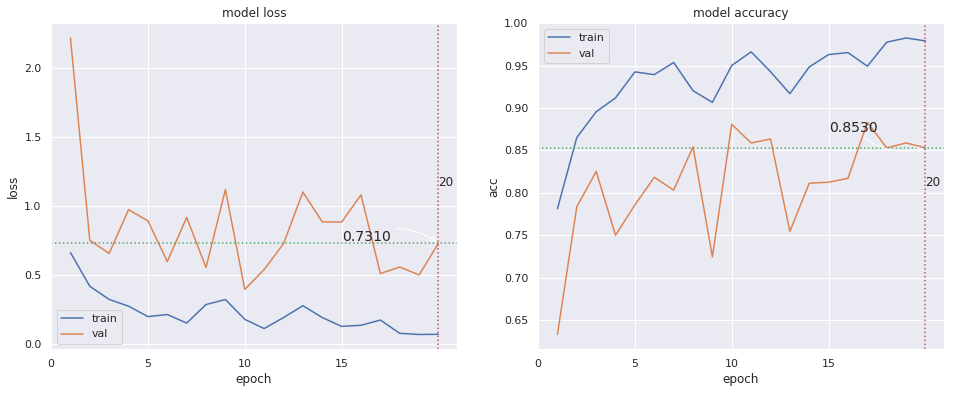

In [0]:
plot_history(history.history)

*Даже непонятно, есть ли тут переобучение: лосс на валидационном датасете вроде как имеет тенденцию к снижению, но очень уж сильно скачет*.

## 4. _Качество модели_

Думаю, что метрики классификации можно оценить по валидационному датасету, потому что он не участвовал в обучении.

In [0]:
test_datagen = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input)

test_generator = test_datagen.flow_from_directory(
    'validation',
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    shuffle=False)

preds = model.predict_generator(test_generator, steps=test_generator.n // test_generator.batch_size, verbose=1)

predicted_class_indices = np.argmax(preds, axis=1)

Found 864 images belonging to 5 classes.
864/864 [==============================] - 10s 12ms/step


In [0]:
test_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [0]:
target_labels = list(test_generator.class_indices.keys())

print( classification_report(test_generator.classes, predicted_class_indices, target_names=target_labels) )

              precision    recall  f1-score   support

       daisy       0.91      0.92      0.91       148
   dandelion       0.88      0.94      0.91       235
        rose       0.95      0.58      0.72       175
   sunflower       0.92      0.90      0.91       136
       tulip       0.70      0.92      0.80       170

    accuracy                           0.85       864
   macro avg       0.87      0.85      0.85       864
weighted avg       0.87      0.85      0.85       864



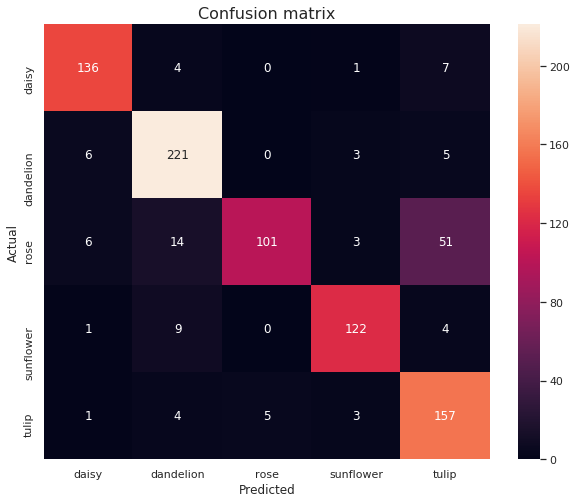

In [0]:
conf_matrix = confusion_matrix(test_generator.classes, predicted_class_indices)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=target_labels, yticklabels=target_labels, annot=True, fmt='d')
plt.title('Confusion matrix', fontsize=16)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();

*В целом, точность класификации довольно неплохая. Только на розах много ошибается*.